## Tokenizing and TF-IDF Vectorization:  Text-based Cosine Similarity
#### In this notebook, I will process the text data to each movie, doing final cleaning of punctuation, making all words lowercase and spliting text into individual word "tokens" (N.B., for those who are text processing-savvy, this was done outside of Vectorizers in order to retain the '-', since curse words are represented in these reviews as s--t and f--k. The frequency with which these curse words appear in reviews may be an important text feature for parents).

#### Tokenized text will then be vectorized using TF-IDF Vectorizer. TF-IDF Vectorizer will take the frequency of words found in text and divide by the frequency with which each term appears in all documents put together. This technique is designed to give greater weight to terms that occur frequently in a document but not in other documents, thus controlling for words that appear frequently in all movies--- such as the word, "movie," for example. It will then turn the TF-IDF statistic into the movie's "word vector." These word vectors will then be run through Truncated SVD.

#### Truncated SVD is a procedure designed to capture the most variance in our collected movie word vectors using the fewest possible components. Each component is a linear combination of word vectors, each word contributing to each component by a particular positive or negative weight (see below for examples). I will then analyze these components to see if I can derive some meaning from the words that contribute to them (see below).

#### Once we get our text data into truncatedSVD format, I will then use cosine similarity to determine which movies are most similar to which other movies in our data set. Cosine similarity is a procedure whereby movies whose associated text contains similar words will be described by vectors that "point in similar directions," if you will, through the vector space defined by truncatedSVD. Movies with vectors that point in similar directions will have higher cosine similarities and so will be deemed to be similar according to this movie recommender.

#### We will then also incorporate non-text data to see how this improves our cosine similarity-based similarity matrix (see below).

### Load Movie Text Data

In [1]:
import pandas as pd
import numpy as np
import requests, re, json, copy, pickle
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

/Users/yukiharuhadeishi/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Load json of movies_features_text
with open('data/movies_features_text.json') as json_file:  
    movies_features_text = json.load(json_file)

In [3]:
df = pd.DataFrame(movies_features_text)
df.head()

,movie_id,slug,text,title
0,0,the-music-of-silence,Families can talk about how The Music of Silen...,The Music of Silence
1,1,the-miseducation-of-cameron-post,Families can talk about how The Miseducation o...,The Miseducation of Cameron Post
2,2,the-spy-who-dumped-me,Families can talk about whether The Spy Who Du...,The Spy Who Dumped Me
3,3,the-darkest-minds,Families can talk about The Darkest Minds and ...,The Darkest Minds
4,4,like-father,Families can talk about the elements that make...,Like Father


In [4]:
def get_movie_list(last_movie):
    for movie_num in range(last_movie):
        movie_titles = movies_features_text[movie_num]['title']
        return movie_titles

In [5]:
movies_features_text[0]['text'][:380]

"Families can talk about how The Music of Silence portrays Bocelli  blindness. How does it compare to other representations of disabilities you've seen on-screen? Does it feel realistic? Do you think it gave a real picture of Bocelli  personal struggle?   How accurate do you think the movie is to actual events overall? Why might filmmakers decide to change the facts in a movie t"

In [6]:
stopwords = set(stopwords.words('english'))
# Remove punctuation from all text of each movie and remove stopwords
def clean_text_for_movie(text):
    '''
    Takes in all text of a single movie, makes lowercase and removes punctuation and stopwords
    from text. Returns words in input text as a single string, w/o English stopwords.
    '''
    words = re.sub("[^a-zA-Z\-]", " ", text).lower().split()  # removes punctuation, makes lowercase
    cleantext = [w for w in words if not w in stopwords]  # eliminates common "stop words"
    return(" ".join(cleantext))  # returns words as a string, each word separated by a space

In [7]:
clean_text_test = clean_text_for_movie(movies_features_text[0]['text'])

In [8]:
clean_text_test[:259]

'families talk music silence portrays bocelli blindness compare representations disabilities seen on-screen feel realistic think gave real picture bocelli personal struggle accurate think movie actual events overall might filmmakers decide change facts movie b'

In [9]:
clean_text = []
def clean_text_for_movies(first_movie, num_movies_to_clean):
    print("Number of movies cleaned so far:")
    for movie in range(num_movies_to_clean):
        movie = (movie + first_movie)
        if movie % 1000 == 0:
            print(movie)
        clean_txt = clean_text_for_movie(movies_features_text[movie]['text'])
        movies_features_text[movie]['clean_text'] = clean_txt
        clean_text.append(clean_txt)
    return clean_text

In [10]:
clean_text = clean_text_for_movies(0,len(movies_features_text))

Number of movies cleaned so far:
0
1000
2000
3000
4000
5000
6000
7000
8000


In [11]:
df = pd.DataFrame(movies_features_text)
df.head()

,clean_text,movie_id,slug,text,title
0,families talk music silence portrays bocelli b...,0,the-music-of-silence,Families can talk about how The Music of Silen...,The Music of Silence
1,families talk miseducation cameron post depict...,1,the-miseducation-of-cameron-post,Families can talk about how The Miseducation o...,The Miseducation of Cameron Post
2,families talk whether spy dumped defies gender...,2,the-spy-who-dumped-me,Families can talk about whether The Spy Who Du...,The Spy Who Dumped Me
3,families talk darkest minds popularity post-ap...,3,the-darkest-minds,Families can talk about The Darkest Minds and ...,The Darkest Minds
4,families talk elements make movie predictable ...,4,like-father,Families can talk about the elements that make...,Like Father


#### Movies_features_text now has two new features, one of which contains the list of words used in movie reviews and other text associated with each of our 8625 unique movies and a second list that contains a list of bigrams of these words, to capture names of actors, separated by sentence. movies_fetures_text is now ready for vectorization.

### Vectorize text for NLP:  TF-IDF
#### In this notebook, I will use a process called TF-IDF (Term Frequency Inverse Document Frequency) Vectorization on my text data. TF-IDF gives the frequency of each word in the words associated with each movie (termed a "document") normalized by the frequency with which that word appears in all of the documents combined. In other words, words that appear frequently in text associated with all movies in general are not going to be counted as important as words that appear frequently in a small subset of documents.
#### After TD-IDF vectorization, I will then use truncated SVD on text data alone to reduce the number of features to reduce overfitting. The components that result from truncated SVD will be examined to identify discernable patterns.

In [12]:
tvec = TfidfVectorizer(analyzer = "word",
                       tokenizer = None,      # tokenized in preprocessing
                       preprocessor = None,
                       stop_words = None,     # english stop words already removed, to retain -
                       min_df = 2,            # to eliminate typos
                       max_df = .9,           # to eliminate the word "movie"
                       max_features = 50000) 

In [13]:
# Do not run unless if you want to TF-IDF Vectorize tokens. Could take some time.
data_features_tfidf = pd.SparseDataFrame(tvec.fit_transform(clean_text),
                                         columns=tvec.get_feature_names(),
                                         default_fill_value=0)

In [14]:
feature_names = tvec.get_feature_names()

In [15]:
len(feature_names)

42391

In [16]:
feature_names[2:4]

['aaah', 'aardman']

### Put Vectorized Data in DF for Analysis
- Sum aggregate token counts
- Plot / investigate
  - Histogram
  - Horizontal Barplot

In [17]:
text = pd.DataFrame.to_dense(data_features_tfidf)

In [18]:
sum_text = text.sum()

In [19]:
sum_text.sort_values(ascending=False)[202:20399]

drugs              48.597784
someone            48.416434
body               48.356881
nothing            48.071137
smoke              48.052971
original           47.943440
throughout         47.815423
although           47.729836
john               47.717432
play               47.671893
comes              47.520574
kissing            47.420418
human              47.365833
evil               47.353814
head               47.307865
images             47.262249
along              47.113910
relationships      46.938453
less               46.832985
animated           46.772306
lead               46.738376
wants              46.461828
tries              46.428890
bit                46.392897
always             46.371288
adult              46.310380
drunk              46.283272
everyone           46.195931
age                46.070253
guy                46.058798
                     ...    
contraption         0.653265
chronologically     0.653190
ultimatum           0.653133
jailbreak     

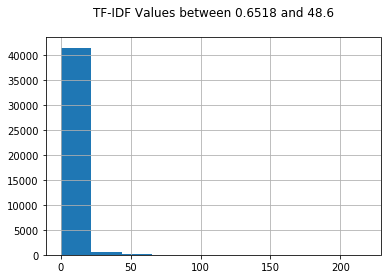

In [20]:
fig, ax = plt.subplots()
sum_text.hist()
ax.set_title("TF-IDF Values between 0.6518 and 48.6\n");

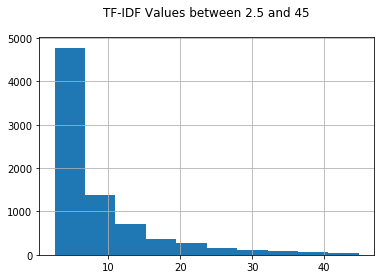

In [21]:
fig, ax = plt.subplots()
mask = sum_text.between(2.5, 45)
sum_text[mask].sort_values(ascending=False).hist()
ax.set_title("TF-IDF Values between 2.5 and 45\n");

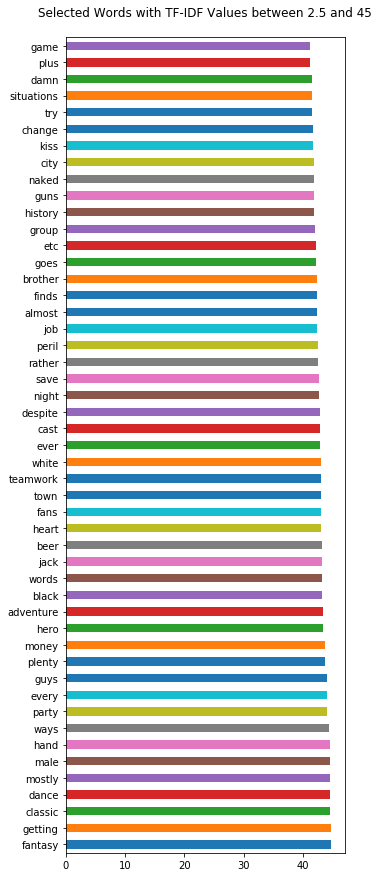

In [22]:
fig, ax = plt.subplots()
sum_text[mask].sort_values(ascending=False)[1:50].plot(kind="barh", figsize=(5, 15));
ax.set_title("Selected Words with TF-IDF Values between 2.5 and 45\n");

### Truncated SVD
#### To generate vectors that encapsulate the most variance in our text data in the fewest number of components.

In [23]:
svd = TruncatedSVD(n_components=4000)

In [24]:
# tfidfvec_truncated is fit_transformed w/4000 components. Will only work if TF-IDF
# vectorizer already run.
tfidfvec_truncated = svd.fit_transform(data_features_tfidf)

In [25]:
# # tfidfvec_truncated is fit_transformed w/4000 components. Will only work if TF-IDF
# # vectorizer already run.
# columns are svd components, 0 - 3999, for tf-idf vectorized words; index is words
components_tfidfvec = pd.DataFrame(svd.components_.T, index=feature_names)

#### Explore components to identify meanings of components

In [26]:
word_importance_component_1 = components_tfidfvec[0].sort_values(ascending=False)

In [27]:
word_importances1 = pd.DataFrame(word_importance_component_1[0:6])

In [28]:
word_importances1_1 = word_importance_component_1[-7:-1]

In [29]:
word_importances1_top_bottom = pd.concat([word_importances1, word_importances1_1])
word_importances1_top_bottom

,0
characters,0.145266
one,0.140366
sex,0.115215
character,0.111734
violence,0.106998
film,0.106700
sheeran,0.000025
beliebers,0.000025
persson,0.000023
sundberg,0.000023


#### It is important to note that all word vector loadings on this first SVD component are positive. This makes sense since the word vector space is relatively shallow with words that do not occur in the text associated with the movie having a value of zero and words that do occur having some non-zero positive value. Therefore, even after SVD transformation, all coefficients will be slightly positive. 
#### The first component appears to be just common words found in our movie reviews--- it is only possibly meaningful that 'sex' and 'violence' load quite heavily on this first component but this could just be because these words are used commonly throughout our corpus. The words that contribute least to our component appear to be mostly typos. This first component, then, is probably best interpreted as representing words of little specific meaning and should be ignored.
#### Components beyond the first, however, seem to be fairly intepretable.

In [30]:
word_importance_component_2 = components_tfidfvec[1].sort_values(ascending=False)

In [31]:
word_importances2 = pd.DataFrame(word_importance_component_2[0:6])

In [32]:
word_importances2_1 = pd.DataFrame(word_importance_component_2[-7:-1])

In [33]:
word_importances2_top_bottom = pd.concat([word_importances2, word_importances2_1])
word_importances2_top_bottom

,1
christmas,0.299352
kids,0.204384
santa,0.140136
holiday,0.135573
dog,0.135007
family,0.130619
nudity,-0.098574
violence,-0.103154
women,-0.103231
shown,-0.110099


In [34]:
word_importance_component_3 = components_tfidfvec[2].sort_values(ascending=False)

In [35]:
word_importances3 = pd.DataFrame(word_importance_component_3[0:6])

In [36]:
word_importances3_1 = pd.DataFrame(word_importance_component_3[-7:-1])

In [37]:
word_importances3_top_bottom = pd.concat([word_importances3, word_importances3_1])
word_importances3_top_bottom

,2
school,0.202506
sex,0.172742
teen,0.153694
girls,0.117247
teens,0.116549
christmas,0.111580
evil,-0.092416
horror,-0.095568
scary,-0.100250
blood,-0.113938


In [38]:
word_importance_component_6 = components_tfidfvec[5].sort_values(ascending=False)

In [39]:
word_importances6 = pd.DataFrame(word_importance_component_6[0:6])

In [40]:
word_importances6_1 = pd.DataFrame(word_importance_component_6[-7:-1])

In [41]:
word_importances6_top_bottom = pd.concat([word_importances6, word_importances6_1])
word_importances6_top_bottom

,5
dog,0.454138
dogs,0.208265
animals,0.182773
animal,0.126161
family,0.123042
man,0.101487
santa,-0.124146
war,-0.125354
teen,-0.165602
girls,-0.172722


In [42]:
word_importance_component_8 = components_tfidfvec[7].sort_values(ascending=False)

In [43]:
word_importances8 = pd.DataFrame(word_importance_component_8[0:6])

In [44]:
word_importances8_1 = pd.DataFrame(word_importance_component_8[-7:-1])

In [45]:
word_importances8_top_bottom = pd.concat([word_importances8, word_importances8_1])
word_importances8_top_bottom

,7
dog,0.431535
war,0.208582
dogs,0.189314
team,0.166184
school,0.161498
sports,0.140653
magic,-0.071783
fantasy,-0.077627
horror,-0.083653
fairy,-0.093807


#### Examining the words that contribute the most to the above components, both positively and negatively, we can begin to interpret what substantial loadings on each of these components represents. For example, Component 8 above (numbered 7 since our components are zero indexed) could be called "Real World Things of importance to Stereotypical Guys." Dogs, war, team, school, and sports all load strongly on this component, while magic, fantasy, horror, fairy, scary, and for some reason love all load negatively. Similarly, component 2 above might be called "Things With Positive Emotional Valence to Puritanical Parents" with Christmas, kids, santa, holiday, dog, and family being the highest positive contributors to the component while nudity, violence, women, shown, drug, and sexual being the highest negative contributors. As recognizers of patterns, we can easily derive meaning from these components; a useful lesson in semiotics.

#### Variance cumulatively explained by SVD Components

In [46]:
# How do I turn this list of cumulative explained variance into a graph?
# On the same graph has a bar point of the amount of variance explained by each component
y = svd.explained_variance_ratio_.cumsum()
print(y)

[0.00223899 0.00709392 0.0108037  ... 0.8156689  0.81573645 0.81580396]


In [48]:
cum_explained_var = []
for i in range(0, len(svd.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(svd.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(svd.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

[0.0022389855061153183, 0.0070939178684922, 0.010803703785389215, 0.014027156041824487, 0.016796459518121625, 0.01926337224442196, 0.021642076601088585, 0.023795291707399746, 0.025649891504676208, 0.02744519102167023, 0.029153243046972237, 0.030851118262546134, 0.03248701365126303, 0.034104630154337186, 0.03567728303089272, 0.037182695653776104, 0.038625580887765194, 0.040044140970484365, 0.04143674677565964, 0.042792503346291935, 0.04412759182021268, 0.04541519569849662, 0.04668879987552137, 0.047926423775281723, 0.04914092808481194, 0.05031397076952262, 0.05146531660097881, 0.05259044805611778, 0.053713861848510056, 0.05481195985396708, 0.05589618036552127, 0.056966314634150673, 0.05800958143363797, 0.059047608524322864, 0.060064564149485154, 0.061076788402826286, 0.062070846291884155, 0.06305484427379762, 0.06403458777833206, 0.06500623035007817, 0.06597502749471942, 0.0669234111178513, 0.06786760125980525, 0.06880357610999832, 0.06973335387864218, 0.07065899513792126, 0.07156716419

[Text(0,0.5,'Cumulative Explained Variance'),
 Text(0.5,0,'Number of Component'),
 Text(0.5,1,'Explained Variance of Truncated SVD Components After TF-IDF Vectorization')]

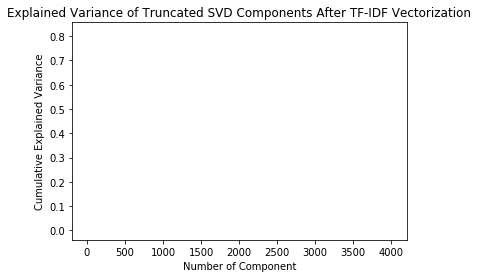

In [49]:
fig, ax = plt.subplots()
for i in range(len(y)):
    ax.plot(i+1, y[i])

ax.set(xlabel='Number of Component', ylabel='Cumulative Explained Variance',
       title='Explained Variance of Truncated SVD Components After TF-IDF Vectorization')

#### Cosine Similarity:  TFIDF_truncSVD4000

In [50]:
### Calcualte as matrix of all movies to all movies of tfidfvec_truncated, the first 1000
sim_matrix_tfidfvec_truncSVD4000 = cosine_similarity(tfidfvec_truncated, tfidfvec_truncated)

In [51]:
### Create similarity matrix of movie similarity scores with titles as indicies and as
### column headers to facilitate cosine similarity based movie lookup (see notebook 7. 8)
similarity_matrix_tfidfvec_truncSVD4000 = pd.DataFrame(sim_matrix_tfidfvec_truncSVD4000,
                                                       columns=df['title'], index=df['title'])

In [52]:
pickle.dump(similarity_matrix_tfidfvec_truncSVD4000,
            open("similarity_matrix_tfidfvec_truncSVD4000.pkl", "wb" ))

In [53]:
similarity_matrix_tfidfvec_truncSVD4000.head()

title,The Music of Silence,The Miseducation of Cameron Post,The Spy Who Dumped Me,The Darkest Minds,Like Father,Urban Country,Christopher Robin,Tully,Overboard,The Miracle Season,...,Live and Let Die,Tintin: The Lake of Sharks,Tales of Beatrix Potter,Tintin: The Prisoners of the Sun,Gentle Giant,Tintin: The Calculus Affair,Visit to a Small Planet,Zoo Baby,Driftwood,Sherlock Jr.
title,,,,,,,,,,,,,,,,,,,,,
The Music of Silence,1.000000,0.059734,0.058564,0.057937,0.074993,0.067051,0.051015,0.034199,0.056023,0.091008,...,0.034361,0.030064,0.034067,0.015418,0.046274,0.022146,0.051117,0.028620,0.054215,0.051583
The Miseducation of Cameron Post,0.059734,1.000000,0.067507,0.129151,0.043704,0.071067,0.036046,0.029031,0.086434,0.064652,...,0.060151,0.022900,0.031000,0.028283,0.025641,0.023473,0.048221,0.025641,0.053179,0.040037
The Spy Who Dumped Me,0.058564,0.067507,1.000000,0.091225,0.073297,0.072628,0.057176,0.056445,0.121835,0.086740,...,0.096829,0.075568,0.028426,0.033298,0.036169,0.047219,0.108649,0.036854,0.066276,0.058551
The Darkest Minds,0.057937,0.129151,0.091225,1.000000,0.047692,0.077370,0.051541,0.041855,0.059723,0.065501,...,0.067916,0.035088,0.061676,0.035141,0.044777,0.042846,0.039921,0.019656,0.050514,0.047867
Like Father,0.074993,0.043704,0.073297,0.047692,1.000000,0.039858,0.058486,0.037485,0.054508,0.064297,...,0.047880,0.024135,0.031013,0.029928,0.051073,0.017638,0.055914,0.030236,0.036238,0.034552


In [54]:
# Example of now the similarity matrix is used, looking up movies similar to
# 'The Music of Silence'
pd.DataFrame(similarity_matrix_tfidfvec_truncSVD4000['The Music of Silence'].sort_values(ascending=False)[1:6].index)
            

,title
0,A Tale of Love and Darkness
1,The Fox and the Hound
2,20 Feet from Stardom
3,The Basket
4,Aaliyah: The Princess of R&amp;B


In [55]:
# Only run this cell if you have run the previous notebooks up through the previous cell,
# generating a new cosine similarity matrix, similarity_matrix_tfidfvec_truncSVD4000.
# As an added layer of protection, you will also need to move the file into the /data
# folder. Then, uncomment this cell and run it.
with open('data/similarity_matrix_tfidfvec_truncSVD4000.pkl', 'rb') as f:
    similarity_matrix_tfidfvec_truncSVD4000 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/similarity_matrix_tfidfvec_truncSVD4000.pkl'

### Export Similarity Matrix in several formats for backup and comparison of file size

In [ ]:
type(similarity_matrix_tfidfvec_truncSVD4000)

In [ ]:
np.save('data/sim_matrix_tfidfvec_truncSVD4000.npy', sim_matrix_tfidfvec_truncSVD1000)

In [ ]:
similarity_matrix_tfidfvec_truncSVD4000.to_csv('data/similarity_matrix_tfidfvec_truncSVD4000.csv')

### Find Similar Movies
#### These functions are also present in interface.py for use in notebook 8-User_Interface.ipynb.

In [ ]:
movie_list = df['title']

In [ ]:
movie_list[0:5]

In [ ]:
def title_recommender(movie_name, movie_list, limit=3):
    results = process.extract(movie_name, movie_list, limit=limit)
    return results

In [ ]:
def find_similar_movies():
    movie_name = input("Give me a movie title and I'll give you five titles you might also like:")
    for title in df['title']:
        if title == movie_name:
            sim_movies_text = similarity_matrix_tfidfvec_truncSVD1000[movie_name]
            print("Thanks! Here are my recommendations, along with review text similarity scores:")
            recommendations = pd.DataFrame(sim_movies_text.sort_values(ascending=False)[1:6])
            return recommendations
    limit = 3
    while title != movie_name:
        results = title_recommender(movie_name, df['title'], limit=limit)
        print("Sorry, that movie title isn't in my list. Did you mean", results, "?")
        movie_name = input("(I need the exact title, please...)")
        for title in df['title']:
            if title == movie_name:
                sim_movies_text = similarity_matrix_tfidfvec_truncSVD1000[movie_name]
                print("Thanks! Here are my recommendations, along with review text similarity scores:")
                recommendations = pd.DataFrame(sim_movies_text.sort_values(ascending=False)[1:6])
                return recommendations
            else:
                limit += 1
                if limit >= 10:
                    limit = 10

In [ ]:
def find_all_similar_movies():
    movie_name = input("Give me a movie title and I'll give you five titles you might also like:")
    for title in df['title']:
        if title == movie_name:
            sim_movies_text = similarity_matrix_tfidfvec_truncSVD1000[movie_name]
            print("Thanks! Here are my recommendations, along with review text similarity scores:")
            recommendations = pd.DataFrame(sim_movies_text.sort_values(ascending=False), index=df['title'])
            return recommendations
    limit = 3
    while title != movie_name:
        results = title_recommender(movie_name, df['title'], limit=limit)
        print("Sorry, that movie title isn't in my list. Did you mean", results, "?")
        movie_name = input("(I need the exact title, please...)")
        for title in df['title']:
            if title == movie_name:
                sim_movies_text = similarity_matrix_tfidfvec_truncSVD1000[movie_name]
                print("Thanks! Here are my recommendations, along with review text similarity scores:")
                recommendations = pd.DataFrame(sim_movies_text.sort_values(ascending=False), index=df['title'])
                return recommendations
            else:
                limit += 1
                if limit >= 10:
                    limit = 10

### Recommender System Evaluation
#### To evaluate my recommender system, I will have my colleagues test out the system, recording what they thought about each recommendation on a 6 point scale (5 = excellent recommendation, 4= good, 3= fair, 2 = poor, 1 = unrelated, 0 = IDK, that's a movie I've never seen)

In [ ]:
def system_test(trials):
    rate_recs = []
    for trial in reversed(range(trials)):
        print("Thank you for trying out MovieRec4Parents(tm)! You have", trial+1, "tries to go.")
        recommendations = find_similar_movies()
        print(recommendations)
        rate_recs.append(recommendations)
        for rec in range(len(recommendations)):
            print("On a scale of 1-5, how good is recommendation", rec+1,"? If you don't know the movie, enter 0.)")
            rating = input()
            rate_recs.append((trial, rec+1, rating))
    print("You're done! I hope you enjoyed using MovieRec4Parents(tm). Tell your friends!")
    return rate_recs

#### To get cosine similarity matrix necessary to run working movie recommender system, you will need to download a 568MB pkl file, similarity_matrix_tfidfvec_truncSVD4000.pkl, currently housed on my google drive. Click here to access the [link](https://drive.google.com/open?id=1kcyVzlulQJ8ViMBCOa_nRxBTA4IaoNBy) or cut and paste this link https://drive.google.com/open?id=1kcyVzlulQJ8ViMBCOa_nRxBTA4IaoNBy .
#### If you have any questions, feel free to email me at hadeishi@gmail.com .